In [2]:
# Author: Syed Hamid Ali
# windcirculation@gmail.com
# github.com/syedhamidali
print('Importing Libraries')
import datetime as dt
tstart = dt.datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import wradlib as wrl
import pandas as pd
import geopandas as gpd
import glob
import os
from matplotlib import axes
from matplotlib.ticker import NullFormatter
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import warnings
warnings.filterwarnings('ignore')
print('Importing Libraries Done')

In [5]:
print('Loading Data...')
fdir = os.getcwd()
files = sorted(glob.glob(fdir+'/MDV-20180602-001130-PPIVol.nc'))
print('No. of Files: ',len(files))
site = (73.87,18.04,1310)
fname = '/home/PDTC/PDTCHACPL/MCRKalapureddy/Hamid/data/DEM/India_Districts_ADM2_GADM/India_Districts_ADM2_GADM.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none',ec='gray',alpha=0.7)
print('Data Loading Complete')

Loading Data...
No. of Files:  1
Data Loading Complete


In [6]:
for filename in files:
    print('Reading File: ', filename)
    vol = wrl.io.open_cfradial1_dataset(filename)
    print('Iterating over sweeps and stacking points')
    swp_list = []
    print('Creating 3D Grid')
    for v in vol:
         # georeference and stack dimensions
        swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
        swp_list.append(swp)
    # concat sweeps to volume
    vol0 = xr.concat(swp_list, dim="points")
    # Create XYZ Coordinate DataArray
    xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()
    # Create Target 3D Grid
    trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), 500)
    trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), 500)
    trgz = np.linspace(0, 20000, 40)
    yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
    trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
    # Create Gridder/Interpolator
    trgshape=xx.shape
    gridder = wrl.vpr.CAPPI(polcoords=xyz,
                         gridcoords=trgxyz,
                         gridshape=trgshape,
                         maxrange=125000,
                         minelev=0,
                         maxelev=90,
                         ipclass=wrl.ipol.Nearest)
    print('Interpolating Data into 3D Grids')
    # Interpolate Data into 3D Grid
    crtd_ref = vol0.UH.where(((vol0.RHOHV < 1.0) & (vol0.ZDR>-4) & ((vol0.PHIDP > 150) | (vol0.PHIDP < -150))))
    vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))
    trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
    trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
    trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
    print('Gridding Complete')
    print('Plotting Max-Z')

Reading File:  /home/PDTC/PDTCHACPL/MCRKalapureddy/Hamid/data/20180602/MDV-20180602-001130-PPIVol.nc
Iterating over sweeps and stacking points
Creating Grid
Interpolating Data into 3D Grids
Gridding Complete
Plotting Max-Z


11:32:21.550300


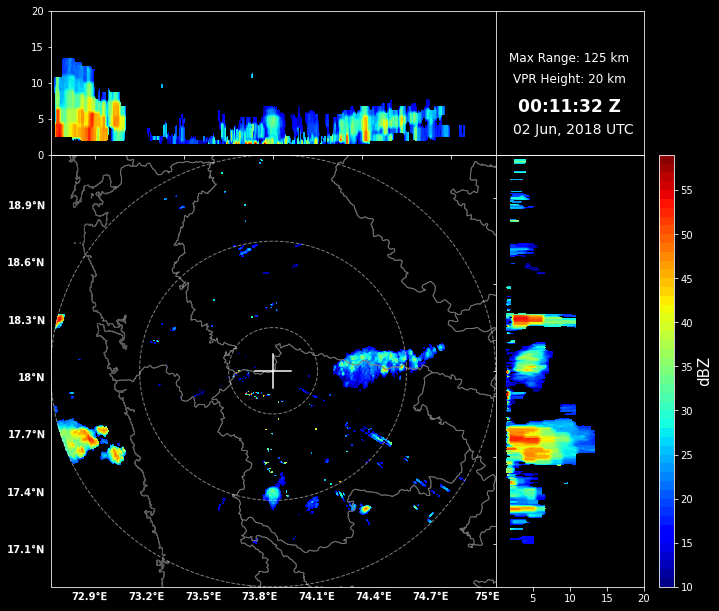

In [22]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(10.3,10))
# define axes
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
ax_xy = plt.axes((left, bottom, width, width),projection=ccrs.AzimuthalEquidistant(73.869,18.04))
ax_x = plt.axes((left, bottom + width, width, height))
ax_y = plt.axes((left + width, bottom, height, width))
ax_cnr = plt.axes((left+width, bottom + width, left+left,height))
ax_cb = plt.axes((left + width + height + 0.02, bottom, 0.02, width))

# set axis label formatters
ax_x.xaxis.set_major_formatter(NullFormatter())
ax_y.yaxis.set_major_formatter(NullFormatter())
ax_cnr.yaxis.set_major_formatter(NullFormatter())
ax_cnr.xaxis.set_major_formatter(NullFormatter())

# # label axes
# ax_xy.set_xlabel("Longitude [°E]",fontsize=15)
# ax_xy.set_ylabel("Latitude [°N]",fontsize=15)
# ax_x.set_xlabel("")
# ax_x.set_ylabel("Height AMSL (km)",fontsize=15)
# ax_y.set_ylabel("")
# ax_y.set_xlabel("Height AMSL (km)",fontsize=15)

# draw CAPPI
plt.sca(ax_xy)
xy = ax_xy.contourf(trgx,trgy,vol_zh.max(axis=0),cmap='jet',levels=range(10,60))
gl = ax_xy.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                     linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold'}
gl.ylabel_style = {'weight': 'bold'}

ax_xy.add_feature(shape_feature) 
[ax_xy.plot(r * np.cos(np.arange(0,360) * np.pi / 180), 
         r * np.sin(np.arange(0,360) * np.pi / 180), 'w--', linewidth=1, alpha=0.5) for r in [25000,75000,125000]]
ax_xy.set_xlim(-125000,125000)
ax_xy.set_ylim(-125000,125000)
ax_xy.plot([0,0],[-10000,10000],'w-')
ax_xy.plot([-10000,10000],[0,0],'w-')

# draw colorbar
cb = plt.colorbar(xy, cax=ax_cb)
cb.set_label('dBZ',fontsize=15)

plt.sca(ax_x)
plt.contourf(trgx/1e3,trgz/1e3,vol_zh.max(axis=1),cmap='jet',levels=range(10,60))
# plt.ylim(0,20)
# plt.yticks([0,5,10,15,20])
# plt.grid(axis='y')

plt.sca(ax_y)
plt.contourf(trgz/1e3,trgy/1e3,vol_zh.max(axis=2).T,cmap='jet',levels=range(10,60))
# plt.xlim(0,20)
ax_y.set_xticks([5,10,15,20])
# plt.grid(axis='x')

plt.sca(ax_cnr)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
# labels along the bottom edge are off
plt.text(0.09,0.65,'Max Range: 125 km',fontsize=12)
plt.text(0.12,0.5,'VPR Height: 20 km',fontsize=12)
plt.text(0.15,0.3,pd.to_datetime(vol[0].time.values).strftime('%H:%M:%S Z'),weight='bold',fontsize=17)
plt.text(0.12,0.15,pd.to_datetime(vol[0].time.values).strftime('%d %b, %Y UTC'),fontsize=14)
ax_xy.set_aspect('auto')
# plt.savefig('plots/'+'Shp_Max-Z_'+str(filename[-29:82])+'.jpg',dpi=200,bbox_inches='tight')
print(dt.datetime.now()-tstart)